In [12]:
import importlib
import model.Portfolio as Portfolio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# importlib.reload(Portfolio)

In [2]:
names = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD", "BTC"]
p = Portfolio.Portfolio()

# Add all assets
for name in names:
    p.addAsset(f"data/{name}.csv", name)

# Convert non SGD assets to SGD
p.addExchangeRate("data/forex/SGDEUR.csv", "EUR", True)
p.addExchangeRate("data/forex/USDSGD.csv", "USD", False)
p.exchangeAdjustment(0, "EUR")
p.exchangeAdjustment(3, "USD")
p.exchangeAdjustment(4, "USD")
p.exchangeAdjustment(5, "USD")
p.exchangeAdjustment(8, "USD")
p.exchangeAdjustment(9, "USD")

In [3]:
currentWeight = [
    0.08992020522,
    0.2744348384,
    0.03070927321,
    0.01896821775,
    0.06166520726,
    0.06204753154,
    0.02053451402,
    0.3393806347,
    0.102339578,
]

p.portfolioPerformance(currentWeight)

{'returns': 0.046602380697228225,
 'variance': 0.004724437320510276,
 'sharpe': 9.864112387503281}

In [4]:
def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)
    return w

In [7]:
%%time

noSimulations = 1000
rf = 0.02
simWeights = []
simRets = []
simVols = []
simSharpes = []

for i in range(noSimulations):
    weights = randomWeight(len(names))
    perf = p.portfolioPerformance(weights, rf=rf)

    simWeights.append(weights)
    simRets.append(perf["returns"])
    simVols.append(perf["variance"])
    simSharpes.append(perf["sharpe"])

CPU times: user 3.2 s, sys: 0 ns, total: 3.2 s
Wall time: 3.2 s


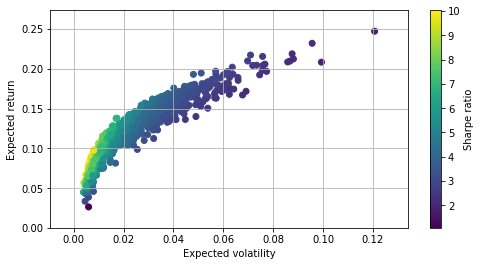

In [10]:
plt.figure(figsize=(8, 4))
plt.scatter(simVols, simRets, c=simSharpes, marker="o")
plt.grid(True)
plt.xlabel("Expected volatility")
plt.ylabel("Expected return")
plt.colorbar(label="Sharpe ratio")
plt.show()

In [14]:
# Get top 10 portfolio with highest sharpe
sortedIndices = np.argsort(simSharpes)[-10:]

results = []
for x in sortedIndices:
    results.append(np.insert(simWeights[x], 0, [simSharpes[x], simRets[x], simVols[x]]))
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + names)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD,BTC
0,9.625884,0.080735,0.006310,0.145117,0.115244,0.020449,0.141200,0.198525,0.001551,0.193575,0.027290,0.137258,0.019793
1,9.692194,0.097966,0.008044,0.115254,0.171918,0.007061,0.052921,0.150497,0.202028,0.001449,0.161596,0.094772,0.042505
2,9.710198,0.085110,0.006705,0.174095,0.227514,0.062523,0.044917,0.139438,0.170955,0.001758,0.060845,0.086021,0.031933
3,9.711750,0.075542,0.005719,0.104861,0.237990,0.076070,0.045984,0.191433,0.043435,0.053745,0.082969,0.123429,0.040083
4,9.797327,0.080311,0.006156,0.133239,0.155950,0.018414,0.129060,0.156110,0.043696,0.055669,0.138470,0.152055,0.017337
5,9.806000,0.087717,0.006906,0.135607,0.161712,0.017000,0.099806,0.155974,0.030168,0.018494,0.178811,0.167982,0.034446
6,9.866909,0.089178,0.007011,0.126062,0.131871,0.051964,0.155274,0.213701,0.019186,0.087783,0.015556,0.166700,0.031903
7,9.884521,0.091089,0.007192,0.135480,0.164340,0.035163,0.088767,0.163727,0.171726,0.135817,0.045475,0.020196,0.039309
8,9.933274,0.081271,0.006168,0.062692,0.139710,0.077793,0.104752,0.193251,0.135549,0.020549,0.179305,0.050336,0.036064
9,10.024030,0.066781,0.004667,0.211758,0.152719,0.104035,0.008334,0.203971,0.140248,0.047981,0.089565,0.025842,0.015546


In [28]:
import scipy.optimize as sco
import numpy as np

class Optimizer:
    def __init__(self, portfolio):
        self.portfolio = portfolio

    def optimize(self):
        numberOfAssets = len(self.portfolio.assetNames)
        constraints = {"type": "eq", "fun": lambda x: np.sum(abs(x)) - 1}
        bounds = tuple((0, 1) for x in range(numberOfAssets))
        initial = np.array(numberOfAssets * [1.0 / numberOfAssets])
        options = sco.minimize(
            lambda x: -self.portfolio.portfolioPerformance(x, rf=0.02)["sharpe"],
            initial,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )
        print(options)
        return options["x"]

In [29]:
%%time
o = Optimizer(p)
optimiserWeight = o.optimize()

     fun: -16.825623170149214
     jac: array([10.320086  , 10.32507968, 29.0620153 , 11.3801825 , 10.32740974,
       10.3241365 , 10.32181072, 10.32520843, 18.95101333, 10.31759048])
 message: 'Optimization terminated successfully.'
    nfev: 206
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.1685908 , 0.16565275, 0.        , 0.        , 0.50039283,
       0.04323066, 0.01559638, 0.09344825, 0.        , 0.01308833])
CPU times: user 754 ms, sys: 0 ns, total: 754 ms
Wall time: 751 ms


In [30]:
p.portfolioPerformance(optimiserWeight)

{'returns': 0.07176797140197455,
 'variance': 0.003076734268827409,
 'sharpe': 23.326022051727737}

In [32]:
dict(zip(names, optimiserWeight))

{'VUSA': 0.16859079866869434,
 'A35': 0.1656527473150624,
 'S59': 0.0,
 'VUSD': 0.0,
 'BAB': 0.5003928298601455,
 'IWDA': 0.04323066028400976,
 'Z74': 0.015596381524557066,
 'ES3': 0.09344824927743772,
 'VWRD': 0.0,
 'BTC': 0.013088333075637518}

## Next Step

- Timeseries K-fold validation when generating weights
    - Monte carlo on K-1 segments of data
    - Test result on 1 segment of data
- Genetics algorithm
- Add backtest capabilities
    - Report over the entire period
    - Custom period

## Even More Advanced Shits

- Selective optimisation for time period (ie interest rate hike, financial crisis, etc)